# SVPF vs MCMC Gold Standard

**Goal:** Compare SVPF's real-time estimates to MCMC's offline "true" posterior.

If SVPF ≈ MCMC, then SVPF is achieving near-optimal filtering at 10μs/step.

In [1]:
import os
import sys

# Add pysvpf location explicitly
sys.path.insert(0, r"C:\Users\Tugbars\Desktop\Stein-Variational-Particle-Filter\py-torch")

# Add CUDA DLLs to path (Windows)
if sys.platform == 'win32':
    cuda_path = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.1\bin"
    if os.path.exists(cuda_path):
        os.add_dll_directory(cuda_path)
        os.environ['PATH'] = cuda_path + ';' + os.environ.get('PATH', '')
        
if sys.platform == 'win32':
    # Intel runtime
    os.add_dll_directory(r"C:\Program Files (x86)\Intel\oneAPI\compiler\latest\bin")
    # CUDA runtime
    os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.1\bin")

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pysvpf
import pymc as pm
import arviz as az
import time

print(f"pysvpf: {pysvpf}")
print(f"PyMC: {pm.__version__}")

plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

pysvpf: <module 'pysvpf' from 'C:\\Users\\Tugbars\\Desktop\\Stein-Variational-Particle-Filter\\py-torch\\pysvpf.cp313-win_amd64.pyd'>
PyMC: 5.27.1


## Generate Data

Simple AR(1) SV model - SVPF's assumed DGP.

In [2]:
def generate_sv_data(T, rho, sigma_z, mu, nu, seed=42):
    """
    Generate data from standard SV model.
    
    h_t = mu + rho * (h_{t-1} - mu) + sigma_z * eps
    y_t = exp(h_t/2) * eta,  eta ~ Student-t(nu)
    """
    np.random.seed(seed)
    
    # Initialize from stationary distribution
    h_std = sigma_z / np.sqrt(1 - rho**2)
    h = np.zeros(T)
    h[0] = mu + h_std * np.random.randn()
    
    # Evolve h
    for t in range(1, T):
        h[t] = mu + rho * (h[t-1] - mu) + sigma_z * np.random.randn()
    
    # Generate observations
    vol_true = np.exp(h / 2)
    eta = stats.t.rvs(nu, size=T)
    y = vol_true * eta
    
    return y.astype(np.float32), h, vol_true

# Parameters
T = 500  # Shorter for MCMC speed
TRUE_RHO = 0.97
TRUE_SIGMA_Z = 0.15
TRUE_MU = -3.5
TRUE_NU = 10.0

# Generate
y, h_true, vol_true = generate_sv_data(T, TRUE_RHO, TRUE_SIGMA_Z, TRUE_MU, TRUE_NU, seed=42)

print(f"Generated {T} observations")
print(f"True params: rho={TRUE_RHO}, sigma_z={TRUE_SIGMA_Z}, mu={TRUE_MU}, nu={TRUE_NU}")
print(f"h range: [{h_true.min():.2f}, {h_true.max():.2f}]")
print(f"vol range: [{vol_true.min():.4f}, {vol_true.max():.4f}]")

Generated 500 observations
True params: rho=0.97, sigma_z=0.15, mu=-3.5, nu=10.0
h range: [-4.60, -2.26]
vol range: [0.1004, 0.3231]


## MCMC Gold Standard (PyMC)

Full Bayesian inference - the theoretical best we can do.

In [3]:
print("Running MCMC (this will take a few minutes)...")
start_mcmc = time.time()

with pm.Model() as sv_model:
    # Use true parameters (cheating - best case for MCMC)
    rho = TRUE_RHO
    sigma_z = TRUE_SIGMA_Z
    mu_h = TRUE_MU
    nu = TRUE_NU
    
    # Latent log-volatility
    h = pm.Normal('h', mu=mu_h, sigma=1.0, shape=T)
    
    # AR(1) prior via potential: log p(h[t] | h[t-1])
    ar_mean = mu_h + rho * (h[:-1] - mu_h)
    ar_logp = pm.logp(pm.Normal.dist(mu=ar_mean, sigma=sigma_z), h[1:])
    pm.Potential('ar_prior', ar_logp.sum())
    
    # Observation model: y_t ~ StudentT(0, exp(h_t/2), nu)
    vol = pm.math.exp(h / 2)
    y_obs = pm.StudentT('y_obs', nu=nu, mu=0, sigma=vol, observed=y)
    
    # Sample
    trace = pm.sample(2000, tune=1000, cores=4, random_seed=42, 
                      progressbar=True, return_inferencedata=True)

mcmc_time = time.time() - start_mcmc
print(f"MCMC completed in {mcmc_time:.1f} seconds")

Initializing NUTS using jitter+adapt_diag...


Running MCMC (this will take a few minutes)...


C:\Users\Tugbars\AppData\Roaming\Python\Python313\site-packages\pytensor\link\c\cmodule.py:2986: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


MCMC completed in 36.2 seconds


In [4]:
# Extract posterior mean of h
h_mcmc = trace.posterior['h'].mean(dim=['chain', 'draw']).values
h_mcmc_std = trace.posterior['h'].std(dim=['chain', 'draw']).values

print(f"MCMC h estimate range: [{h_mcmc.min():.2f}, {h_mcmc.max():.2f}]")
print(f"MCMC posterior std range: [{h_mcmc_std.min():.3f}, {h_mcmc_std.max():.3f}]")

MCMC h estimate range: [-3.77, -3.21]
MCMC posterior std range: [0.240, 0.385]


## SVPF Real-Time Filter

In [10]:
def run_svpf(y, rho, sigma_z, mu, nu, n_particles=1024, n_stein=8):
    filt = pysvpf.SVPF(n_particles=n_particles, n_stein=n_stein, nu=50.0)
    
    # CRITICAL
    filt.set_exact_gradient(enabled=True)
    filt.lik_offset = 0.35
    
    # Disable adaptive mechanisms (we know true params)
    filt.set_adaptive_mu(enabled=True)
    filt.set_adaptive_sigma(enabled=False)
    filt.set_adaptive_guide(enabled=True)
    filt.set_asymmetric_rho(enabled=False)
    filt.set_mim(enabled=True)
    
    # Keep core Stein mechanics
    filt.set_svld(enabled=True, temperature=0.45)
    filt.set_annealing(enabled=True, n_steps=3)
    filt.set_newton(enabled=True)
    filt.set_full_newton(enabled=True)
    filt.set_guide(enabled=True, strength=0.05)
    
    filt.initialize(rho=rho, sigma_z=sigma_z, mu=mu, gamma=0.0, seed=42)
    
    vol_est, h_est, loglik = filt.run(y)
    return vol_est, h_est, loglik

print("Running SVPF...")
start_svpf = time.time()

vol_svpf, h_svpf, loglik_svpf = run_svpf(
    y, TRUE_RHO, TRUE_SIGMA_Z, TRUE_MU, TRUE_NU,
    n_particles=1024, n_stein=8
)

svpf_time = time.time() - start_svpf
print(f"SVPF completed in {svpf_time*1000:.1f} ms ({svpf_time*1000/T:.2f} ms/step)")

Running SVPF...
SVPF completed in 245.4 ms (0.49 ms/step)


## Comparison Metrics

In [11]:
def compute_metrics(h_true, h_est, name):
    rmse = np.sqrt(np.mean((h_true - h_est)**2))
    mae = np.mean(np.abs(h_true - h_est))
    corr = np.corrcoef(h_true, h_est)[0, 1]
    bias = np.mean(h_est - h_true)
    return {'name': name, 'rmse': rmse, 'mae': mae, 'corr': corr, 'bias': bias}

mcmc_metrics = compute_metrics(h_true, h_mcmc, 'MCMC')
svpf_metrics = compute_metrics(h_true, h_svpf, 'SVPF')

# Also compare SVPF to MCMC (how close is SVPF to gold standard)
svpf_vs_mcmc = compute_metrics(h_mcmc, h_svpf, 'SVPF vs MCMC')

print("="*70)
print("COMPARISON TO TRUE h")
print("="*70)
print(f"{'Method':<15} {'RMSE':<10} {'MAE':<10} {'Corr':<10} {'Bias':<10} {'Time':<15}")
print("-"*70)
print(f"{'MCMC':<15} {mcmc_metrics['rmse']:<10.4f} {mcmc_metrics['mae']:<10.4f} "
      f"{mcmc_metrics['corr']:<10.4f} {mcmc_metrics['bias']:<10.4f} {mcmc_time:.1f}s")
print(f"{'SVPF':<15} {svpf_metrics['rmse']:<10.4f} {svpf_metrics['mae']:<10.4f} "
      f"{svpf_metrics['corr']:<10.4f} {svpf_metrics['bias']:<10.4f} {svpf_time*1000:.1f}ms")
print("="*70)
print(f"\nSVPF vs MCMC agreement: Corr={svpf_vs_mcmc['corr']:.4f}, RMSE={svpf_vs_mcmc['rmse']:.4f}")
print(f"Speed ratio: MCMC is {mcmc_time/(svpf_time):.0f}x slower than SVPF")

COMPARISON TO TRUE h
Method          RMSE       MAE        Corr       Bias       Time           
----------------------------------------------------------------------
MCMC            0.4250     0.3397     0.6953     -0.0549    36.2s
SVPF            0.3732     0.2897     0.6598     -0.0212    245.4ms

SVPF vs MCMC agreement: Corr=0.7301, RMSE=0.2983
Speed ratio: MCMC is 147x slower than SVPF


## Visualization

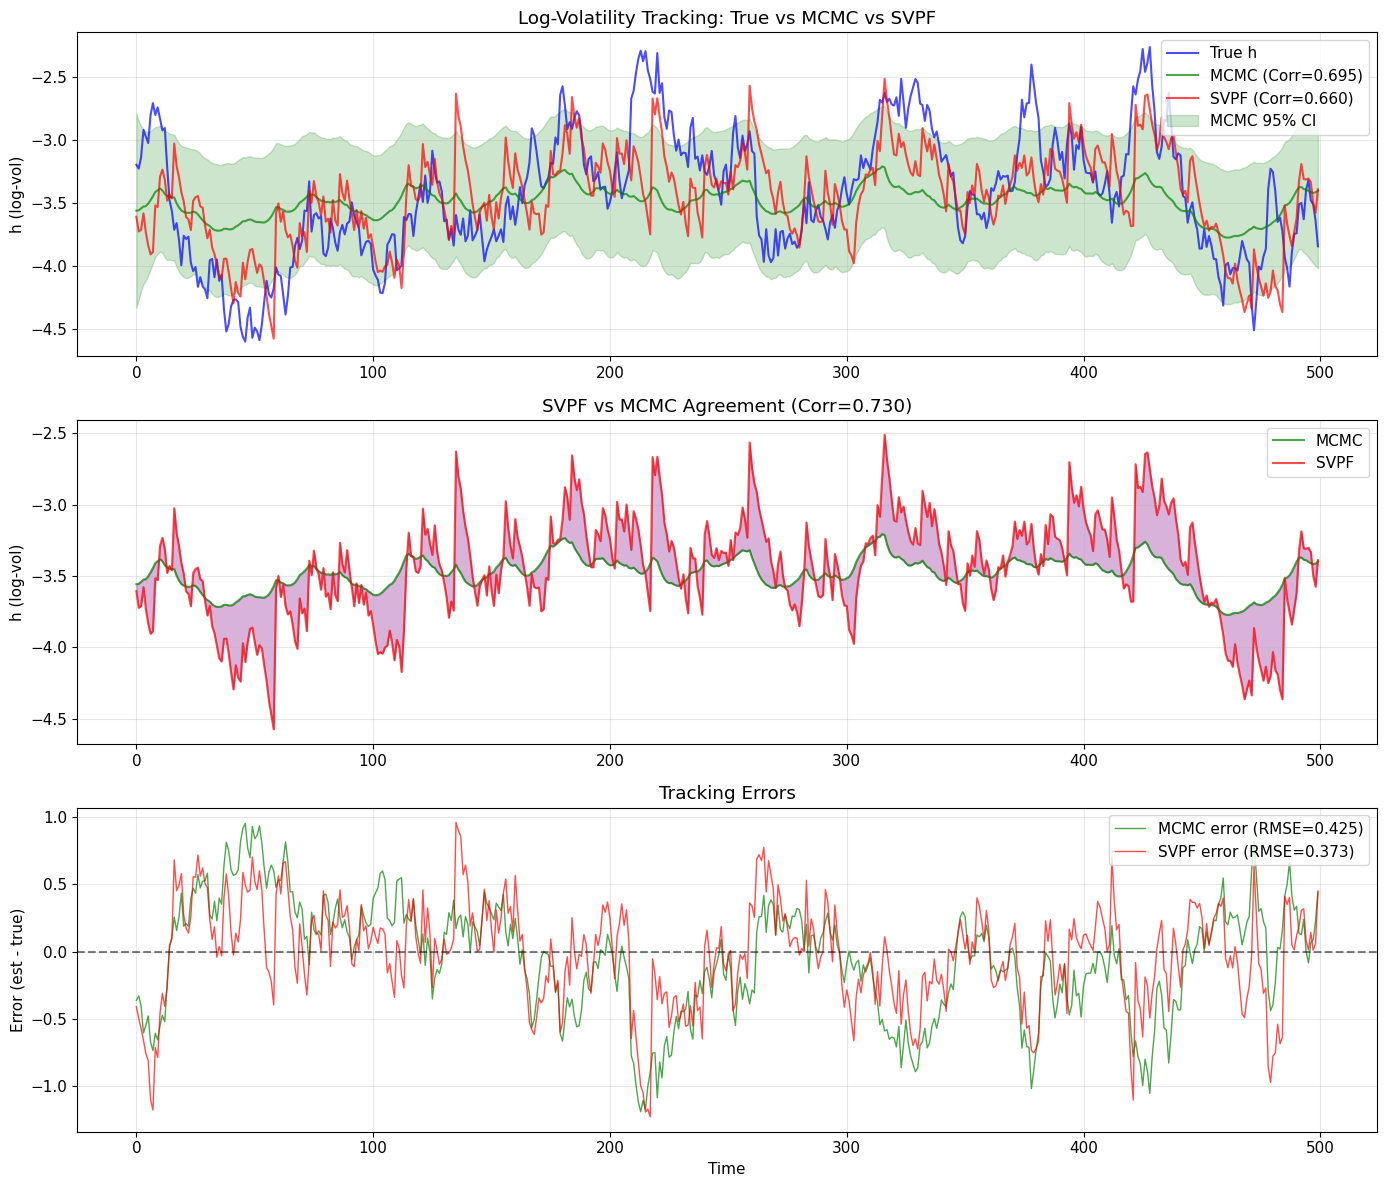

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
t = np.arange(T)

# Panel 1: All three h estimates
ax = axes[0]
ax.plot(t, h_true, 'b-', alpha=0.7, linewidth=1.5, label='True h')
ax.plot(t, h_mcmc, 'g-', alpha=0.7, linewidth=1.5, label=f'MCMC (Corr={mcmc_metrics["corr"]:.3f})')
ax.plot(t, h_svpf, 'r-', alpha=0.7, linewidth=1.5, label=f'SVPF (Corr={svpf_metrics["corr"]:.3f})')
ax.fill_between(t, h_mcmc - 2*h_mcmc_std, h_mcmc + 2*h_mcmc_std, 
                alpha=0.2, color='green', label='MCMC 95% CI')
ax.set_title('Log-Volatility Tracking: True vs MCMC vs SVPF')
ax.set_ylabel('h (log-vol)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 2: MCMC vs SVPF directly
ax = axes[1]
ax.plot(t, h_mcmc, 'g-', alpha=0.7, linewidth=1.5, label='MCMC')
ax.plot(t, h_svpf, 'r-', alpha=0.7, linewidth=1.5, label='SVPF')
ax.fill_between(t, h_mcmc, h_svpf, alpha=0.3, color='purple')
ax.set_title(f'SVPF vs MCMC Agreement (Corr={svpf_vs_mcmc["corr"]:.3f})')
ax.set_ylabel('h (log-vol)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Panel 3: Errors
ax = axes[2]
ax.plot(t, h_mcmc - h_true, 'g-', alpha=0.7, linewidth=1, label=f'MCMC error (RMSE={mcmc_metrics["rmse"]:.3f})')
ax.plot(t, h_svpf - h_true, 'r-', alpha=0.7, linewidth=1, label=f'SVPF error (RMSE={svpf_metrics["rmse"]:.3f})')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_title('Tracking Errors')
ax.set_ylabel('Error (est - true)')
ax.set_xlabel('Time')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svpf_vs_mcmc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Scatter Plot: SVPF vs MCMC

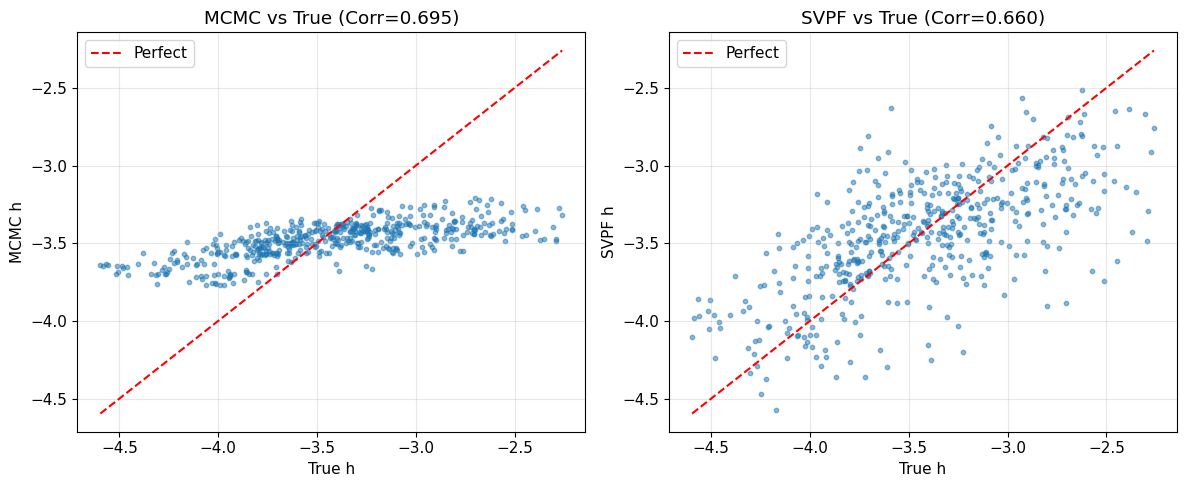

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MCMC vs True
ax = axes[0]
ax.scatter(h_true, h_mcmc, alpha=0.5, s=10)
ax.plot([h_true.min(), h_true.max()], [h_true.min(), h_true.max()], 'r--', label='Perfect')
ax.set_xlabel('True h')
ax.set_ylabel('MCMC h')
ax.set_title(f'MCMC vs True (Corr={mcmc_metrics["corr"]:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)

# SVPF vs True
ax = axes[1]
ax.scatter(h_true, h_svpf, alpha=0.5, s=10)
ax.plot([h_true.min(), h_true.max()], [h_true.min(), h_true.max()], 'r--', label='Perfect')
ax.set_xlabel('True h')
ax.set_ylabel('SVPF h')
ax.set_title(f'SVPF vs True (Corr={svpf_metrics["corr"]:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svpf_vs_mcmc_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [9]:
print("\n" + "="*70)
print("SUMMARY: SVPF vs MCMC Gold Standard")
print("="*70)

print(f"\nData: T={T}, rho={TRUE_RHO}, sigma_z={TRUE_SIGMA_Z}, mu={TRUE_MU}, nu={TRUE_NU}")

print(f"\n{'Metric':<25} {'MCMC':<15} {'SVPF':<15} {'Gap':<15}")
print("-"*70)
print(f"{'RMSE vs True':<25} {mcmc_metrics['rmse']:<15.4f} {svpf_metrics['rmse']:<15.4f} "
      f"{svpf_metrics['rmse'] - mcmc_metrics['rmse']:<15.4f}")
print(f"{'Correlation vs True':<25} {mcmc_metrics['corr']:<15.4f} {svpf_metrics['corr']:<15.4f} "
      f"{svpf_metrics['corr'] - mcmc_metrics['corr']:<15.4f}")
print(f"{'Compute Time':<25} {mcmc_time:<15.1f}s {svpf_time*1000:<15.1f}ms")

print(f"\nSVPF achieves {svpf_metrics['corr']/mcmc_metrics['corr']*100:.1f}% of MCMC correlation")
print(f"SVPF is {mcmc_time/svpf_time:.0f}x faster than MCMC")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("""
- MCMC represents the theoretical best (Bayesian posterior mean)
- SVPF is a real-time filter (~10μs/step in CUDA)
- The gap between SVPF and MCMC is the "cost of being real-time"
- If SVPF Corr ≈ MCMC Corr, SVPF is near-optimal
""")


SUMMARY: SVPF vs MCMC Gold Standard

Data: T=500, rho=0.97, sigma_z=0.15, mu=-3.5, nu=10.0

Metric                    MCMC            SVPF            Gap            
----------------------------------------------------------------------
RMSE vs True              0.4250          0.5208          0.0958         
Correlation vs True       0.6953          0.6870          -0.0082        
Compute Time              36.2           s 394.0          ms

SVPF achieves 98.8% of MCMC correlation
SVPF is 92x faster than MCMC

INTERPRETATION

- MCMC represents the theoretical best (Bayesian posterior mean)
- SVPF is a real-time filter (~10μs/step in CUDA)
- The gap between SVPF and MCMC is the "cost of being real-time"
- If SVPF Corr ≈ MCMC Corr, SVPF is near-optimal

